In [1]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


In [3]:
df = pd.read_csv('ProcessedData.csv')

In [4]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

In [5]:
# Separate features and target
X = df.drop(columns=['final_status_success'])
y = df['final_status_success']

In [6]:
# First split: train_val (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: train (64%) and val (16%) from train_val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

In [7]:
# Convert to DMatrix (XGBoost’s optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)


In [8]:
# Training parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.1,
    "max_depth": 6,
    "seed": 42
}



In [9]:
# Watchlist to monitor training & validation loss
watchlist = [(dtrain, "train"), (dval, "eval")]


In [10]:

# Train with early stopping
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=watchlist,
    early_stopping_rounds=20,
    verbose_eval=10
)

[0]	train-logloss:0.66963	eval-logloss:0.66960
[10]	train-logloss:0.56825	eval-logloss:0.56813
[20]	train-logloss:0.54299	eval-logloss:0.54287
[30]	train-logloss:0.53493	eval-logloss:0.53483
[40]	train-logloss:0.53210	eval-logloss:0.53202
[50]	train-logloss:0.53108	eval-logloss:0.53102
[60]	train-logloss:0.53070	eval-logloss:0.53066
[70]	train-logloss:0.53057	eval-logloss:0.53054
[80]	train-logloss:0.53052	eval-logloss:0.53049
[90]	train-logloss:0.53050	eval-logloss:0.53047
[100]	train-logloss:0.53049	eval-logloss:0.53047
[110]	train-logloss:0.53048	eval-logloss:0.53046
[120]	train-logloss:0.53048	eval-logloss:0.53046
[130]	train-logloss:0.53048	eval-logloss:0.53046
[140]	train-logloss:0.53048	eval-logloss:0.53046
[150]	train-logloss:0.53048	eval-logloss:0.53045
[160]	train-logloss:0.53048	eval-logloss:0.53045
[170]	train-logloss:0.53048	eval-logloss:0.53045
[180]	train-logloss:0.53047	eval-logloss:0.53045
[190]	train-logloss:0.53047	eval-logloss:0.53045
[200]	train-logloss:0.53047	eva

In [11]:
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Test Classification Report:")
print(classification_report(y_test, y_pred))


Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.76     11830
           1       1.00      0.39      0.56     11917

    accuracy                           0.69     23747
   macro avg       0.81      0.69      0.66     23747
weighted avg       0.81      0.69      0.66     23747



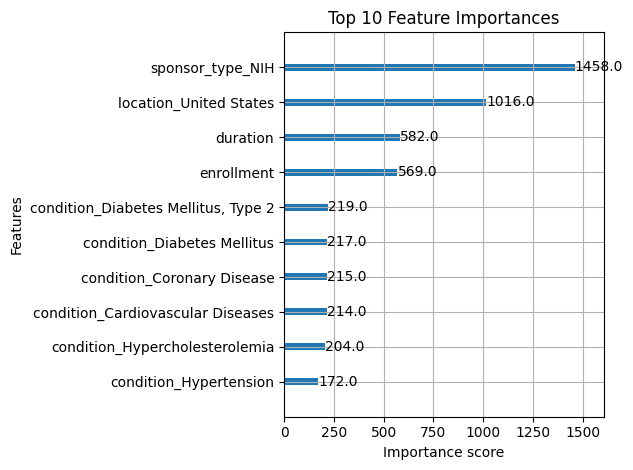

In [12]:
import matplotlib.pyplot as plt

xgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

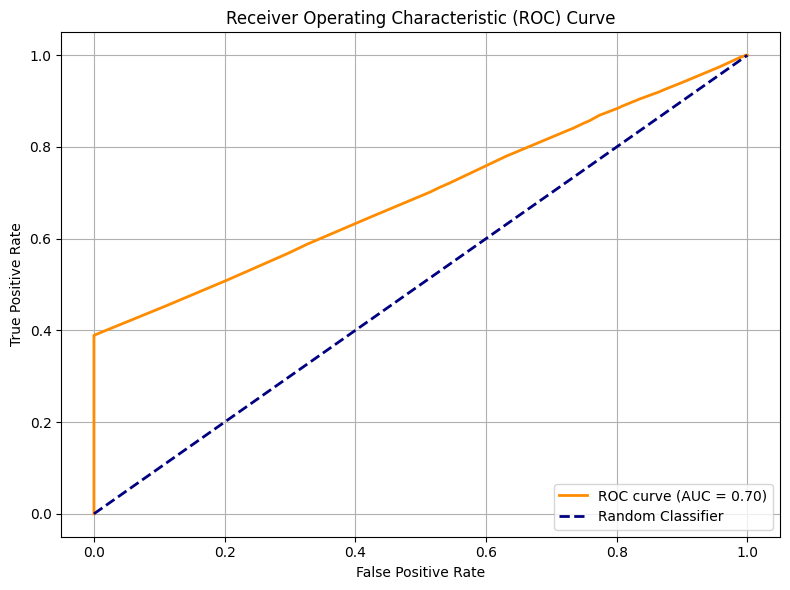

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities on test set
y_pred_prob = model.predict(dtest)

# Get FPR, TPR, thresholds for ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
import numpy as np

In [15]:
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{np.int64(0): np.int64(59150), np.int64(1): np.int64(59582)}


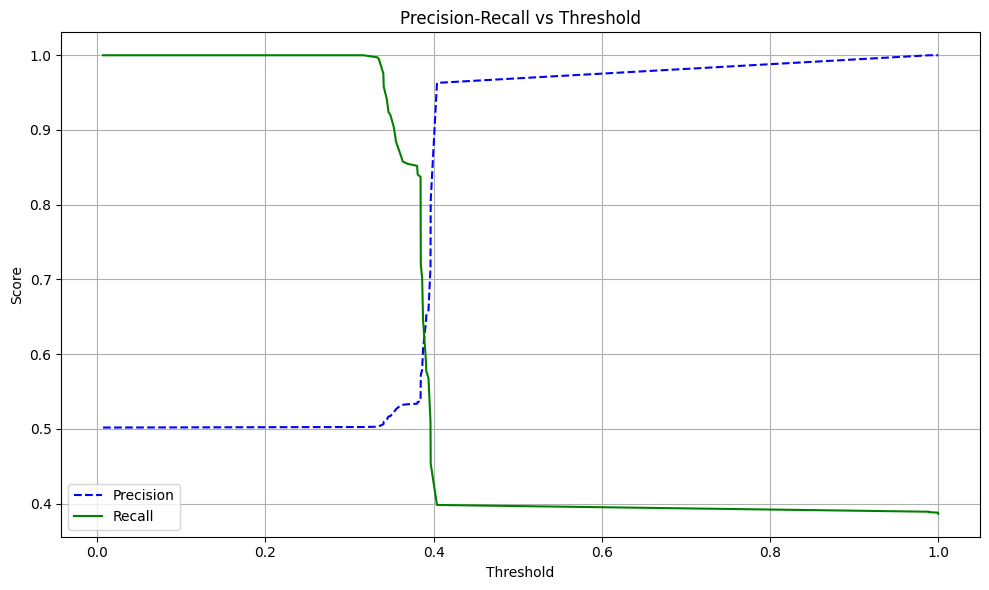

In [16]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities on test set
y_proba = model.predict(dtest)

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Plot Precision-Recall vs Threshold
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
custom_threshold = 0.35
y_pred_custom = (y_proba >= custom_threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.63      0.16      0.26     11830
           1       0.52      0.90      0.66     11917

    accuracy                           0.54     23747
   macro avg       0.58      0.53      0.46     23747
weighted avg       0.58      0.54      0.46     23747



In [18]:
from sklearn.metrics import f1_score
import numpy as np

best_thresh = 0.5
best_f1 = 0

for t in np.arange(0.1, 0.9, 0.01):
    y_pred = (y_proba >= t).astype(int)
    score = f1_score(y_test, y_pred)
    if score > best_f1:
        best_f1 = score
        best_thresh = t

print(f"Best Threshold = {best_thresh:.2f} with F1 Score = {best_f1:.4f}")


Best Threshold = 0.10 with F1 Score = 0.6689


In [19]:
y_pred = (y_proba >= 0.10).astype(int)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.00      0.01     11830
           1       0.50      1.00      0.67     11917

    accuracy                           0.50     23747
   macro avg       0.75      0.50      0.34     23747
weighted avg       0.75      0.50      0.34     23747



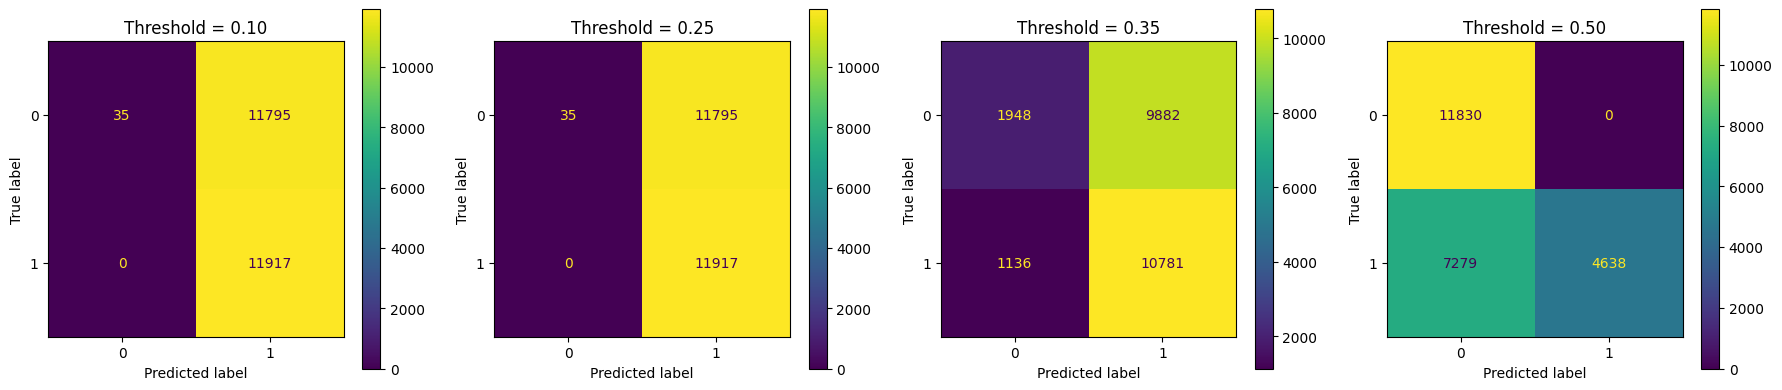

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

thresholds = [0.1, 0.25, 0.35, 0.5]  # You can adjust or add more
fig, axes = plt.subplots(1, len(thresholds), figsize=(18, 4))

for i, thresh in enumerate(thresholds):
    y_pred_thresh = (y_proba >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresh)
    disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], values_format='d')
    axes[i].set_title(f"Threshold = {thresh:.2f}")

plt.tight_layout()
plt.show()
